In [5]:
 import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import cv2

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


**Loading and Preprocessing the Data**

In [6]:
 (x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)


**Data Augmentation**

In [7]:
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
data_gen.fit(x_train)


**Model Design**


In [ ]:
 model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])


**Compiling and Training the Model**

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model.fit(
    data_gen.flow(x_train, y_train, batch_size=64),
    epochs=5,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, lr_reduction]
)


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 143s 178ms/step - accuracy: 0.3241 - loss: 1.9568 - val_accuracy: 0.5112 - val_loss: 1.3680 - learning_rate: 0.0010
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 139s 174ms/step - accuracy: 0.5022 - loss: 1.3958 - val_accuracy: 0.5725 - val_loss: 1.1853 - learning_rate: 0.0010
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 139s 177ms/step - accuracy: 0.5555 - loss: 1.2592 - val_accuracy: 0.5307 - val_loss: 1.3843 - learning_rate: 0.0010
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 134s 171ms/step - accuracy: 0.6006 - loss: 1.1536 - val_accuracy: 0.5748 - val_loss: 1.2670 - learning_rate: 0.0010
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.6206 - loss: 1.0813
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
782/782 ━━━━━━━━━━━━━━━━━━━━ 141s 179ms/step - accuracy: 0.6206 - loss: 1.0813 - val_accuracy: 0.5663 - val_loss: 1.4120 - learning_rate: 0.0010


**Evaluating the Model**

313/313 - 6s - 18ms/step - accuracy: 0.5725 - loss: 1.1853
Test Accuracy: 57.25%


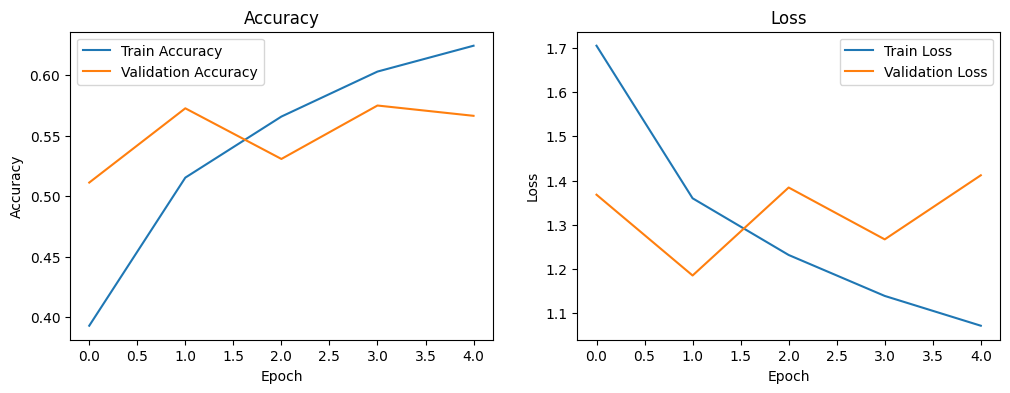

In [10]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


**Confusion Matrix**

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step


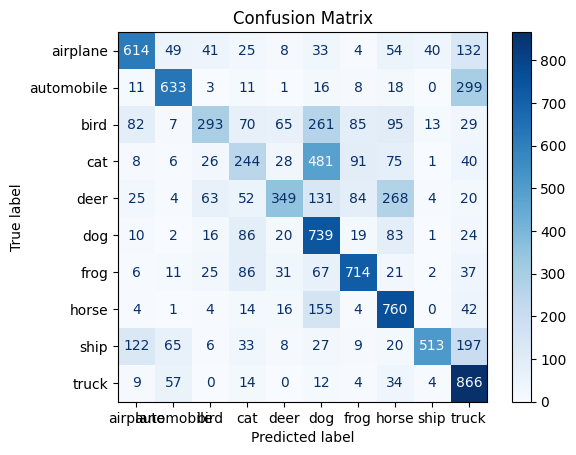

In [11]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


**Class-Wise Accuracy**

In [ ]:
class_wise_accuracy = (conf_matrix.diagonal() / conf_matrix.sum(axis=1)) * 100
for i, acc in enumerate(class_wise_accuracy):
    print(f"Class {class_names[i]} Accuracy: {acc:.2f}%")


**Processing and Predicting a Single Image**

In [13]:
def process_and_predict_image(image_path):
    try:
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError("Image cannot be read. Check the file format or path.")
        img_resized = cv2.resize(img, (32, 32))
        img_normalized = img_resized.astype('float32') / 255.0
        img_normalized = np.expand_dims(img_normalized, axis=0)
        prediction = model.predict(img_normalized)
        predicted_class = prediction.argmax()
        predicted_class_name = class_names[predicted_class]
        print(f'Predicted class index: {predicted_class}')
        print(f'Predicted class name: {predicted_class_name}')
        plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
        plt.title(f"Predicted: {predicted_class_name} ({predicted_class})")
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Error processing the image: {e}")


**User Input and Prediction**

Please enter the full path of the image you want to predict: /content/stray_dog_513872.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted class index: 5
Predicted class name: dog


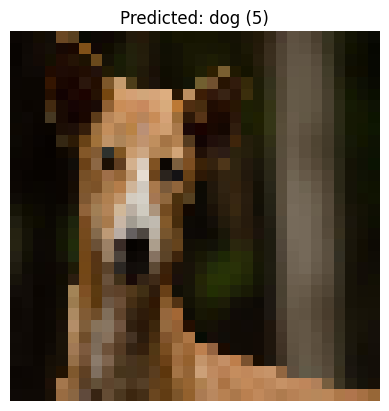

In [14]:
def select_and_predict_image():
    image_path = input("Please enter the full path of the image you want to predict: ")
    if os.path.exists(image_path):
        process_and_predict_image(image_path)
    else:
        print("Invalid file path. Please try again.")

select_and_predict_image()
